In [78]:
# Importing Required Libraries
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, Attention, LayerNormalization
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy, AUC
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from gensim.models import Word2Vec
import numpy as np
from keras.utils import to_categorical
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
import json
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import tokenizer_from_json






Data Preprocessing
We start by reading the data from an Excel file and handling Arabic text.
Next, we drop rows with missing values in the 'stu_answer' column.
We then combine 'stu_answer' and 'id_question' columns into a single column. We also get the 'grade' column.

In [79]:
excel_path = 'Data_all.xlsx'  # Replace with the actual path to your Excel file
data = pd.read_excel(excel_path)
data.dropna(subset=['stu_answer'], inplace=True)
answers = [str(answer) for answer in data['stu_answer'].values]
grades= data['grade'].values



# Tokenization

We tokenize the answers using the Keras Tokenizer.


In [80]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

ps = PorterStemmer()

# Assuming `answers` is a list of sentences
stemmed_answers = []
for sentence in answers:
    words = word_tokenize(sentence)
    stemmed_words = [ps.stem(w) for w in words]
    stemmed_sentence = ' '.join(stemmed_words)
    stemmed_answers.append(stemmed_sentence)

tokenizer = Tokenizer(filters='''!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ''''')
tokenizer.fit_on_texts(answers)

# Save the tokenizer
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))


# Vocabulary Size

We first calculate the vocabulary size, which is the total number of unique words in our data plus one.

# Converting Text to Sequences

We convert the answers to sequences of tokens using the tokenizer we previously fitted on our answers.

# Padding Sequences

To ensure that all sequences have the same length, we pad them using TensorFlow's `pad_sequences` function. We use 'post' padding which means that zeros are added at the end of the sequences.

We then print the shape of the padded sequences to verify the operation.

# Splitting the Data

We split our data into training and testing sets using the `train_test_split` function from `sklearn.model_selection`. We use a test size of 20%, meaning that 20% of our data will be used for testing and the rest for training. We also set a random state for reproducibility.

Finally, we print the shapes of our training and testing sets to verify the split.


In [81]:
vocab_size = len(tokenizer.word_index) + 1

# Convert the answers to sequences of tokens
sequences = tokenizer.texts_to_sequences(answers)

# Pad the sequences to have the same length
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding='post')

# Print the shape of the padded sequences
print(padded_sequences.shape)
grades = to_categorical(grades, num_classes=3)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, grades, test_size=0.2, random_state=42)


# Print the shapes of the training and testing sets
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(1412, 49)
(1129, 49) (1129, 3) (283, 49) (283, 3)


In this code snippet, we define a class called `TransformerBlock` that inherits from the `layers.Layer` class. This class represents a transformer block, which is a fundamental building block in transformer-based models.

The `TransformerBlock` class has an `__init__` method that initializes the attributes of the class. It takes four parameters: `embed_dim`, `num_heads`, `ff_dim`, and `rate`. These parameters determine the dimensions and properties of the transformer block.

Inside the `__init__` method, we define the following attributes:
- `att`: An instance of the `layers.MultiHeadAttention` class, which represents the multi-head attention mechanism in the transformer block.
- `ffn`: A sequential model consisting of two dense layers with ReLU activation. This represents the feed-forward network inside the transformer block.
- `layernorm1` and `layernorm2`: Layer normalization layers that normalize the inputs and outputs of the transformer block.
- `dropout1` and `dropout2`: Dropout layers that apply dropout regularization to the outputs of the attention and feed-forward layers, respectively.

The `call` method of the `TransformerBlock` class takes two parameters: `inputs` and `training`. It performs the forward pass of the transformer block. Here's a step-by-step breakdown of what the `call` method does:
1. It applies the multi-head attention mechanism to the inputs, producing an attention output.
2. It applies dropout regularization to the attention output.
3. It adds the inputs to the attention output and normalizes the result using layer normalization.
4. It passes the normalized output through the feed-forward network.
5. It applies dropout regularization to the feed-forward output.
6. It adds the normalized output of the attention layer to the feed-forward output and normalizes the result using layer normalization.
7. It returns the final output of the transformer block.

Overall, the `TransformerBlock` class encapsulates the operations performed in a single transformer block, making it easier to build and customize transformer-based models.


In [82]:

@keras.utils.register_keras_serializable()
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.25):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


# Token and Position Embedding Class

This class is used to create embeddings for the tokens and their positions in the input sequences.

In the constructor, we initialize two embedding layers:
- `token_emb`: This layer will convert the input tokens (words) into dense vectors of fixed size (`embed_dim`). The input dimension is the size of the vocabulary (`vocab_size`).
- `pos_emb`: This layer will convert the positions of the tokens in the input sequence into dense vectors of fixed size (`embed_dim`). The input dimension is the maximum length of the input sequences (`maxlen`).


In the `call` method, we first get the length of the input sequences (`maxlen`). We then create a tensor of positions, which is just a sequence of integers from 0 to `maxlen`. We pass this tensor through the `pos_emb` layer to get the position embeddings. We also pass the input sequences through the `token_emb` layer to get the token embeddings. Finally, we add the token embeddings and the position embeddings together and return the result.
```


In [83]:
@keras.saving.register_keras_serializable()
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


#here we have our hyper parameter 

In [84]:

# Set the hyperparameters
embed_dim = 300  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
maxlen = padded_sequences.shape[1]


This code defines a machine learning model using a transformer architecture for text classification.
The model takes a sequence of inputs and performs the following steps:
1. Embedding: The inputs are passed through an embedding layer to convert them into dense vectors.
2. Transformer Block: The embedded inputs are then processed by a transformer block, which consists of multi-head self-attention and feed-forward layers.
3. Global Average Pooling: The output of the transformer block is globally averaged along the time dimension.
4. Dense Layer: The averaged output is passed through a dense layer with ReLU activation and L2 regularization.
5. Dropout: A dropout layer is applied to prevent overfitting.
6. Output Layer: The output of the dropout layer is passed through a dense layer with softmax activation and L2 regularization to obtain the final classification probabilities.
7. Model Compilation: The model is compiled with the Adam optimizer, categorical cross-entropy loss, and additional metrics such as accuracy, precision, and recall.
8. Training: The model is trained on the training data with early stopping based on validation loss.
9. Model Saving: The trained model is saved as 'my_model.h5'.

In [85]:



# Define the inputs
inputs = layers.Input(shape=(maxlen,))

# Create the embedding layer
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)

# Create the transformer block
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)

# Perform global average pooling
x = layers.GlobalAveragePooling1D()(x)

# Add a dense layer with ReLU activation and L2 regularization
x = layers.Dense(20, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)

# Add a dropout layer
x = layers.Dropout(0.1)(x)

# Add the output layer with softmax activation and L2 regularization
outputs = layers.Dense(3, activation="softmax", kernel_regularizer=regularizers.l2(0.01))(x)

# Create the model
model = keras.Model(inputs=inputs, outputs=outputs)

# Convert labels to one-hot vectors

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model with the early stopping callback
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Save the model
model.save('my_model.keras')

# Preprocess the input text




Epoch 1/100
18/18 [==============================] - 8s 278ms/step - loss: 1.4290 - accuracy: 0.6182 - precision_7: 0.6287 - recall_7: 0.5908 - val_loss: 1.1555 - val_accuracy: 0.6926 - val_precision_7: 0.7025 - val_recall_7: 0.6926
Epoch 2/100
18/18 [==============================] - 5s 282ms/step - loss: 1.1175 - accuracy: 0.6962 - precision_7: 0.7031 - recall_7: 0.6670 - val_loss: 1.1125 - val_accuracy: 0.6926 - val_precision_7: 0.6950 - val_recall_7: 0.6926
Epoch 3/100
18/18 [==============================] - 5s 267ms/step - loss: 1.0592 - accuracy: 0.6962 - precision_7: 0.7093 - recall_7: 0.6873 - val_loss: 1.0390 - val_accuracy: 0.6926 - val_precision_7: 0.7127 - val_recall_7: 0.6926
Epoch 4/100
18/18 [==============================] - 5s 284ms/step - loss: 1.0068 - accuracy: 0.7121 - precision_7: 0.7257 - recall_7: 0.7006 - val_loss: 0.9834 - val_accuracy: 0.7279 - val_precision_7: 0.7302 - val_recall_7: 0.7173
Epoch 5/100
18/18 [==============================] - 5s 266ms/step -

9/9 [==============================] - 0s 34ms/step - loss: 0.7947 - accuracy: 0.8445 - precision_7: 0.8682 - recall_7: 0.7915
Accuracy: 0.8445229530334473
Precision: 0.8682170510292053
Recall: 0.7915194630622864
F1 Score: 0.8280961323892116
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 49)]              0         
                                                                 
 token_and_position_embeddi  (None, 49, 300)           379200    
 ng_14 (TokenAndPositionEmb                                      
 edding)                                                         
                                                                 
 transformer_block_13 (Tran  (None, 49, 300)           742832    
 sformerBlock)                                                   
                                                                 
 global_average

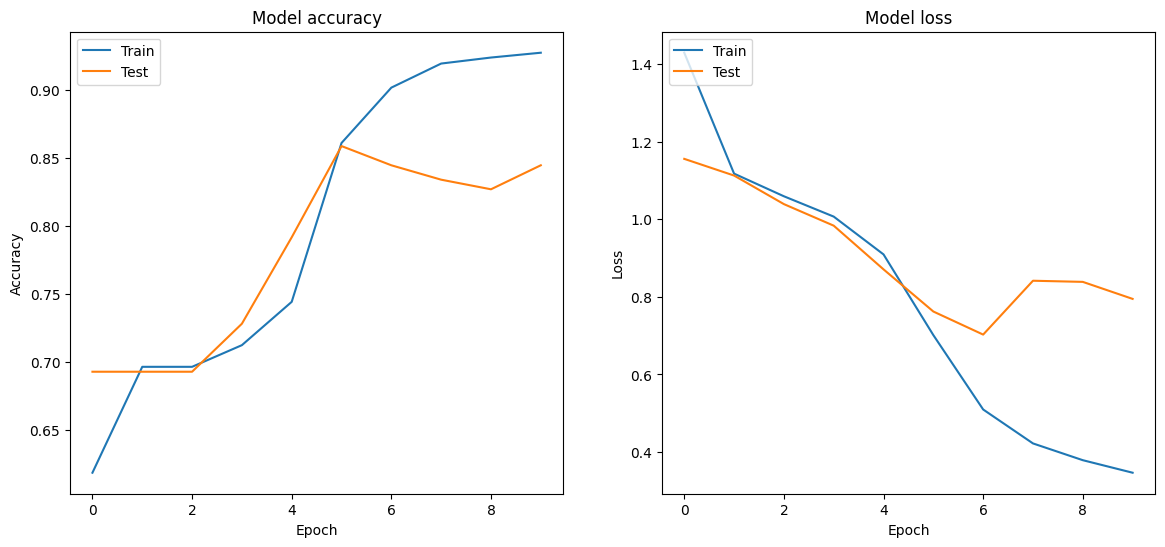

In [86]:
import matplotlib.pyplot as plt
import tensorflow as tf

loss, accuracy, precision, recall = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
f1_score = 2 * (precision * recall) / (precision + recall)
print(f'F1 Score: {f1_score}')

print(model.summary())
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [87]:
scores_trainig = model.evaluate(X_train, y_train, verbose=1)
print("Training Loss: %f%%" % (scores_trainig[0]))
print("Training Accuracy: %.2f%%" % (scores_trainig[1]*100))
print("Training Precision: %.2f%%" % (scores_trainig[2]*100))
print("Training Recall: %.2f%%" % (scores_trainig[3]*100))


36/36 [==============================] - 1s 35ms/step - loss: 0.3327 - accuracy: 0.9221 - precision_7: 0.9602 - recall_7: 0.8981
Training Loss: 0.332655%
Training Accuracy: 92.21%
Training Precision: 96.02%
Training Recall: 89.81%


In [88]:
with open('tokenizer.json') as f:
    data = json.load(f)
    tokenizer = tokenizer_from_json(data)
model = keras.models.load_model('my_model.keras', custom_objects={'TokenAndPositionEmbedding': TokenAndPositionEmbedding})
input_text = "محمد"
input_sequence = tokenizer.texts_to_sequences([input_text])
padded_input_sequence = tf.keras.preprocessing.sequence.pad_sequences(input_sequence, maxlen=maxlen, padding='post')

# Make the prediction
prediction = model.predict(padded_input_sequence)

# Get the predicted class
predicted_class = np.argmax(prediction)

# Print the predicted class
print(predicted_class)


1/1 [==============================] - 0s 194ms/step
0
